<a href="https://colab.research.google.com/github/p0mona/MAD_SWPS_Polina_Bezukladnova_3/blob/main/mad_p.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importuję wszystkie potrzebne biblioteki
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore, stats
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, mean_squared_error, r2_score, confusion_matrix
)

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import time

In [ ]:
#Importuję dataset
url = 'https://raw.githubusercontent.com/p0mona/MAD_SWPS_Polina_Bezukladnova_3/refs/heads/main/apple_quality.csv'
apple: pd.DataFrame = pd.read_csv(url)

In [ ]:
apple.head()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


In [ ]:
#brakujące dane
apple[apple.isnull().any(axis=1)]

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Created_by_Nidula_Elgiriyewithana,NaN


In [ ]:
# Usunięcie brakujących danych
apple = apple.drop(apple.index[-1])

In [ ]:
#Ponowne sprawdzenie
apple[apple.isnull().any(axis=1)]

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality


In [ ]:
#Duplikaty
apple[apple.duplicated()]

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality


In [ ]:
#Zmienna zależna
dep_var = apple['Quality']

#Zmienne niezależne
indep_var = apple.drop(columns=['Quality', 'A_id'])

In [ ]:
#Konwersja danych do tablic NumPy
dep_var_array = np.array(dep_var)
indep_var_array = np.array(indep_var)

In [ ]:
# Analiza statystyczna
indep_var.describe()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,-0.503015,-0.989547,-0.470479,0.985478,0.512118,0.498277
std,1.928059,1.602507,1.943441,1.402757,1.930286,1.874427
min,-7.151703,-7.149848,-6.894485,-6.055058,-5.961897,-5.864599
25%,-1.816765,-2.011770,-1.738425,0.062764,-0.801286,-0.771677
50%,-0.513703,-0.984736,-0.504758,0.998249,0.534219,0.503445
75%,0.805526,0.030976,0.801922,1.894234,1.835976,1.766212
max,6.406367,5.790714,6.374916,7.619852,7.364403,7.237837


In [ ]:
#Zauważyłam, że nie ma 'Acidity', sprawdzam typ danych
indep_var.dtypes

,0
Size,float64
Weight,float64
Sweetness,float64
Crunchiness,float64
Juiciness,float64
Ripeness,float64
Acidity,object


In [ ]:
#'Acidity' typu object -> sprawdzam wartości
mask = pd.to_numeric(indep_var['Acidity'], errors='coerce').isna()
print(indep_var[mask])

Empty DataFrame
Columns: [Size, Weight, Sweetness, Crunchiness, Juiciness, Ripeness, Acidity]
Index: []


In [ ]:
# Nie ma 'złych' wartości, dlatego mogę zmienić typ danych 'Acidity'
indep_var['Acidity'] = pd.to_numeric(indep_var['Acidity'])

In [ ]:
# sprawdzam ponowmie describe()
indep_var.describe()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,-0.503015,-0.989547,-0.470479,0.985478,0.512118,0.498277,0.076877
std,1.928059,1.602507,1.943441,1.402757,1.930286,1.874427,2.110270
min,-7.151703,-7.149848,-6.894485,-6.055058,-5.961897,-5.864599,-7.010538
25%,-1.816765,-2.011770,-1.738425,0.062764,-0.801286,-0.771677,-1.377424
50%,-0.513703,-0.984736,-0.504758,0.998249,0.534219,0.503445,0.022609
75%,0.805526,0.030976,0.801922,1.894234,1.835976,1.766212,1.510493
max,6.406367,5.790714,6.374916,7.619852,7.364403,7.237837,7.404736


In [ ]:
mediana = indep_var.median(numeric_only=True)
print("Mediana:\n", mediana)

Mediana:
 Size          -0.513703
Weight        -0.984736
Sweetness     -0.504758
Crunchiness    0.998249
Juiciness      0.534219
Ripeness       0.503445
Acidity        0.022609
dtype: float64


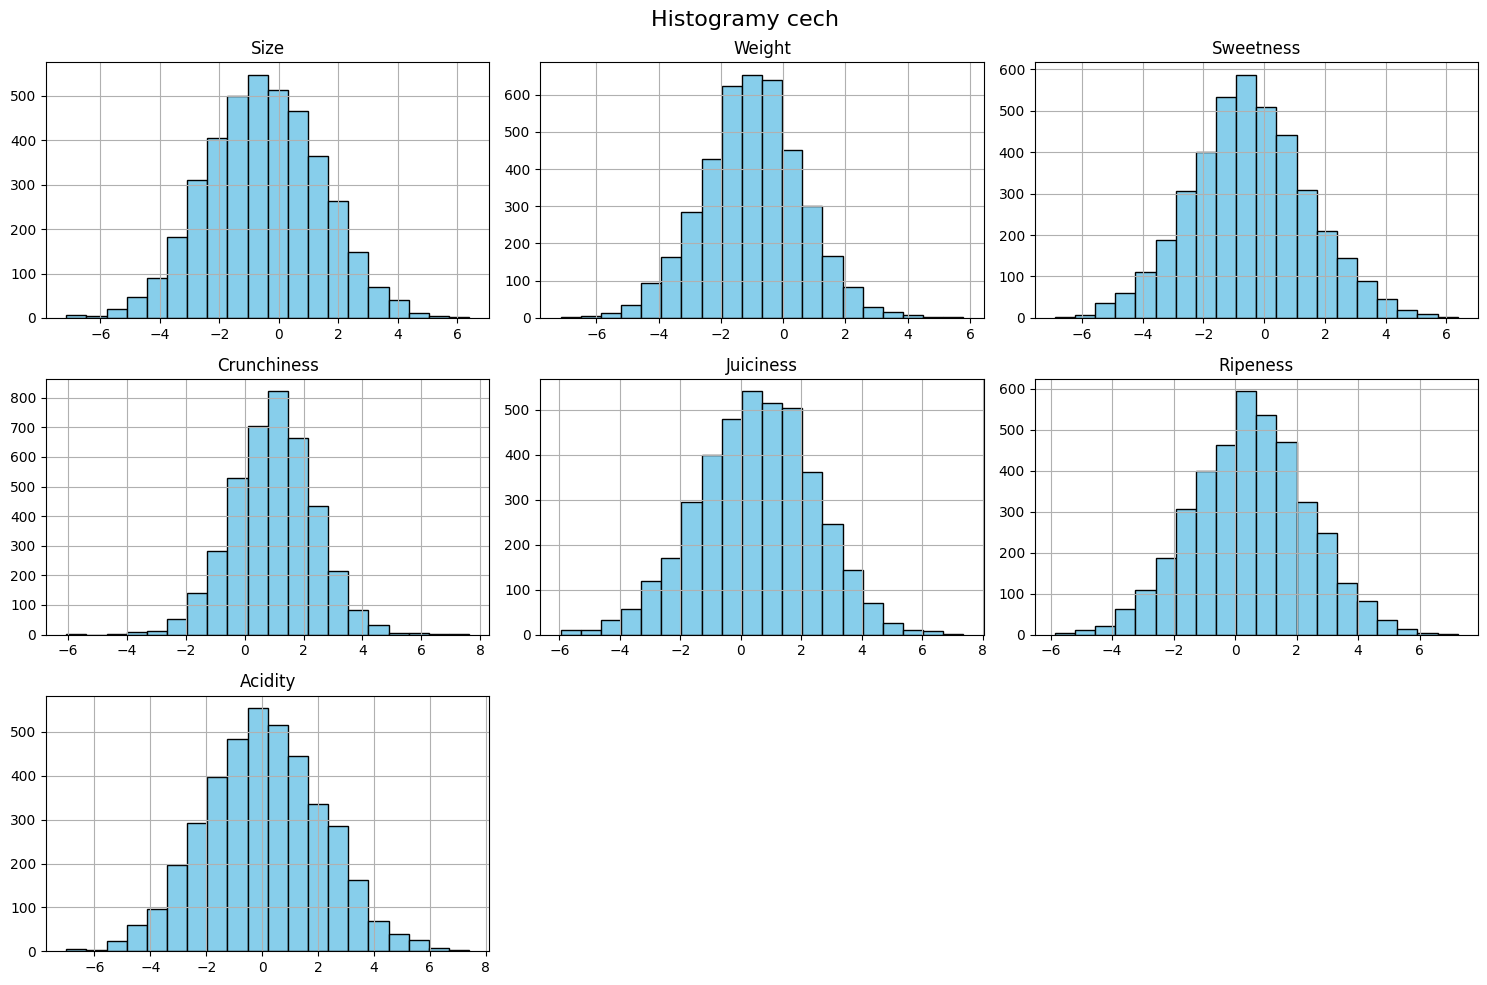

In [ ]:
#Histogramy dla wszystkich zmiennych
indep_var.hist(bins=20, figsize=(15, 10), edgecolor='black', color='skyblue')
plt.suptitle("Histogramy cech", fontsize=16)
plt.tight_layout();

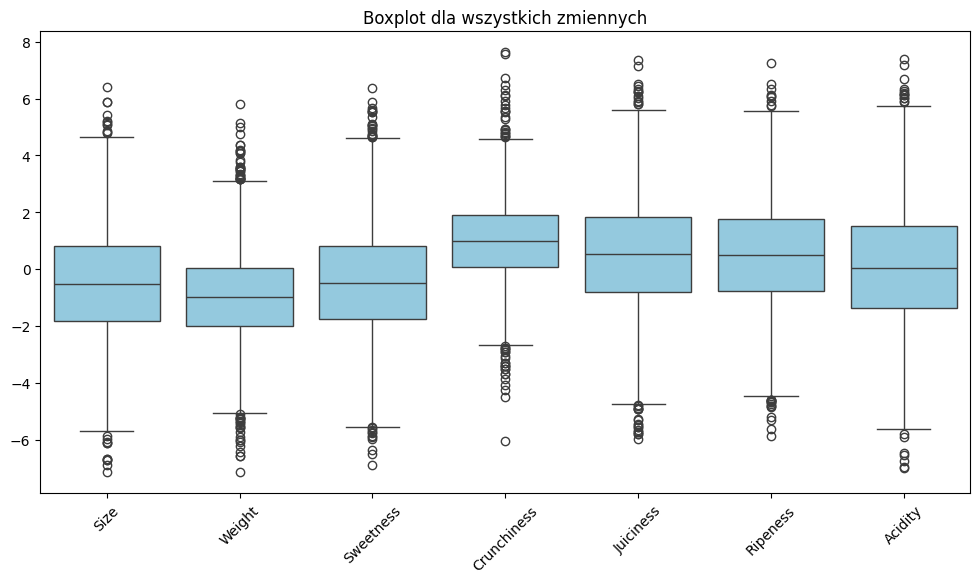

In [ ]:
#Boxploty dla wszyskich zmiennych
plt.figure(figsize=(12, 6))
sns.boxplot(indep_var, color="skyblue")
plt.xticks(rotation=45)
plt.title('Boxplot dla wszystkich zmiennych');

In [ ]:
#Macierz korelacji
matrix_corr = indep_var.corr()
print(matrix_corr)

                 Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness  \
Size         1.000000 -0.170702  -0.324680     0.169868  -0.018892 -0.134773   
Weight      -0.170702  1.000000  -0.154246    -0.095882  -0.092263 -0.243824   
Sweetness   -0.324680 -0.154246   1.000000    -0.037552   0.095882 -0.273800   
Crunchiness  0.169868 -0.095882  -0.037552     1.000000  -0.259607 -0.201982   
Juiciness   -0.018892 -0.092263   0.095882    -0.259607   1.000000 -0.097144   
Ripeness    -0.134773 -0.243824  -0.273800    -0.201982  -0.097144  1.000000   
Acidity      0.196218  0.016414   0.085999     0.069943   0.248714 -0.202669   

              Acidity  
Size         0.196218  
Weight       0.016414  
Sweetness    0.085999  
Crunchiness  0.069943  
Juiciness    0.248714  
Ripeness    -0.202669  
Acidity      1.000000  


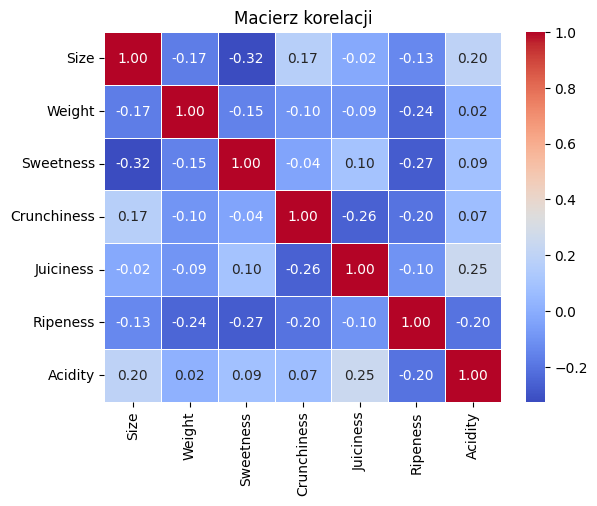

In [ ]:
# Wizualizacji macierzy
sns.heatmap(matrix_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Macierz korelacji');

In [ ]:
# Outliery, wybiram Z-score dlatego że mam rozkład normalny(histogram)
z_scores = np.abs(zscore(indep_var))
threshold = 3
outliers = (z_scores > threshold)

#ilość wartości odstających
print(outliers.sum())

102


In [ ]:
#Usuwam wierszy z wartosciami odstającymi
indep_var_no_outliers = indep_var[~outliers.any(axis=1)]
dep_var_no_outliers = dep_var[~outliers.any(axis=1)]

In [ ]:
# Analiza statystyczna po usunięciu wartości odstających
indep_var_no_outliers.describe()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
count,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000
mean,-0.511937,-0.990995,-0.471125,0.980617,0.519838,0.515593,0.073821
std,1.885896,1.550028,1.910246,1.334950,1.881195,1.839423,2.080966
min,-6.099551,-5.746384,-5.958315,-3.127340,-4.924983,-4.851519,-5.917900
25%,-1.816040,-1.997478,-1.729070,0.077895,-0.791251,-0.734297,-1.376742
50%,-0.524415,-0.984489,-0.504307,0.994335,0.528195,0.521532,0.021319
75%,0.774258,0.021622,0.790041,1.879203,1.825988,1.771178,1.499513
max,5.225383,3.772173,5.346330,4.937210,6.226448,6.102587,6.348870


In [ ]:
mediana = indep_var_no_outliers.median(numeric_only=True)
print("Mediana:\n", mediana)

Mediana:
 Size          -0.524415
Weight        -0.984489
Sweetness     -0.504307
Crunchiness    0.994335
Juiciness      0.528195
Ripeness       0.521532
Acidity        0.021319
dtype: float64


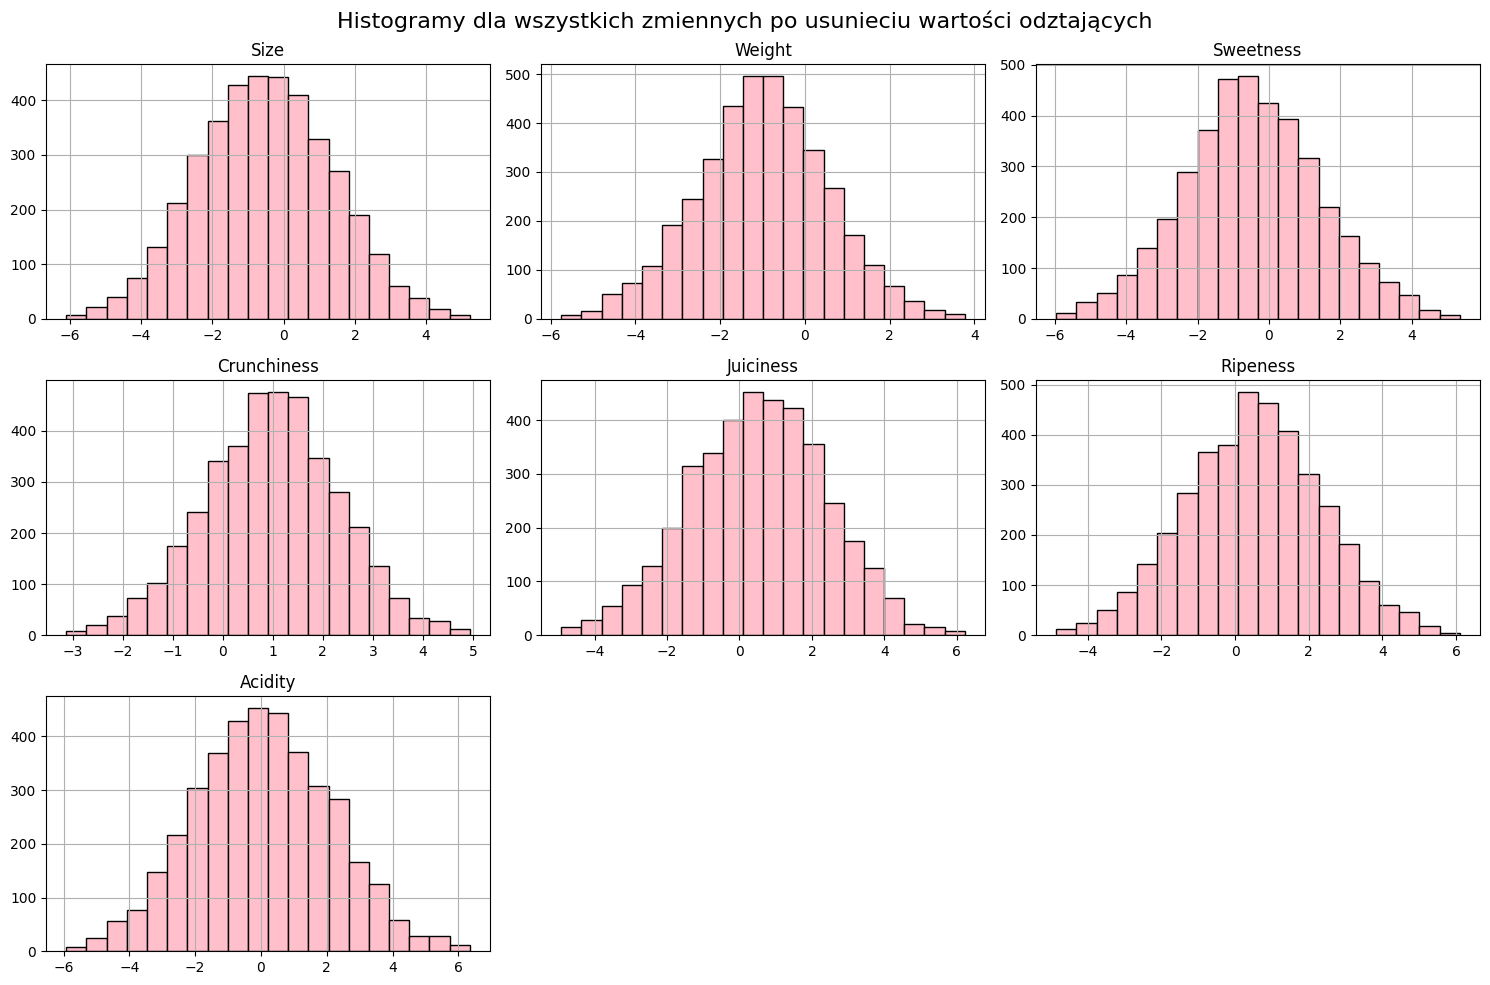

In [ ]:
#Histogramy dla wszystkich zmiennych po usunieciu wartości odstających
indep_var_no_outliers.hist(bins=20, figsize=(15, 10), edgecolor='black', color='pink')
plt.suptitle("Histogramy dla wszystkich zmiennych po usunieciu wartości odztających", fontsize=16)
plt.tight_layout();

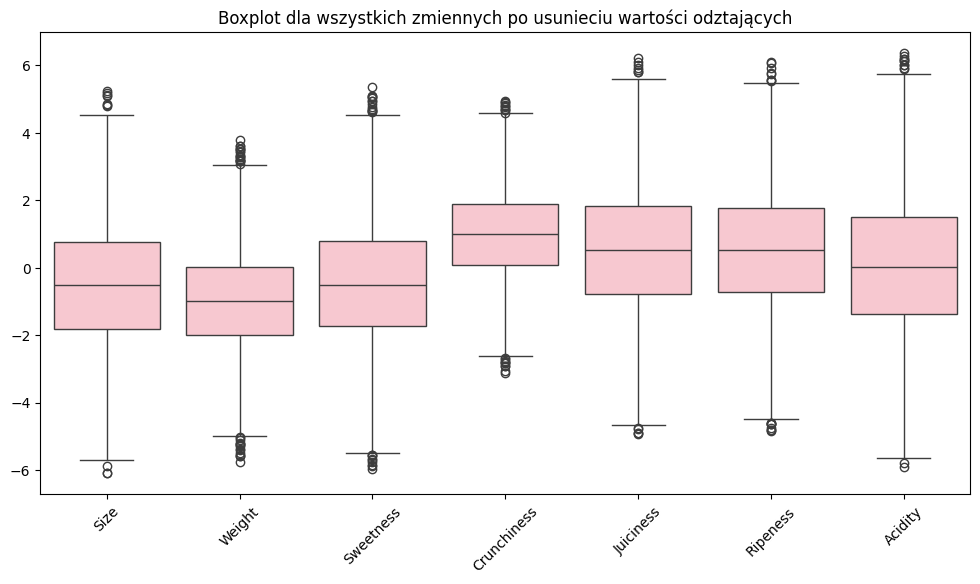

In [ ]:
#Boxploty dla wszyskich zmiennych po usunieciu wartości odstających
plt.figure(figsize=(12, 6))
sns.boxplot(indep_var_no_outliers, color="pink")
plt.xticks(rotation=45)
plt.title('Boxplot dla wszystkich zmiennych po usunieciu wartości odztających');

In [ ]:
#Macierz korelacji po usunieciu wartości odstających
matrix_corr = indep_var_no_outliers.corr()
print(matrix_corr)

                 Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness  \
Size         1.000000 -0.153762  -0.324508     0.160858  -0.018156 -0.144195   
Weight      -0.153762  1.000000  -0.153337    -0.087360  -0.088784 -0.237118   
Sweetness   -0.324508 -0.153337   1.000000    -0.029287   0.084672 -0.272663   
Crunchiness  0.160858 -0.087360  -0.029287     1.000000  -0.242160 -0.198083   
Juiciness   -0.018156 -0.088784   0.084672    -0.242160   1.000000 -0.107505   
Ripeness    -0.144195 -0.237118  -0.272663    -0.198083  -0.107505  1.000000   
Acidity      0.185892  0.026974   0.073379     0.065757   0.244911 -0.198988   

              Acidity  
Size         0.185892  
Weight       0.026974  
Sweetness    0.073379  
Crunchiness  0.065757  
Juiciness    0.244911  
Ripeness    -0.198988  
Acidity      1.000000  


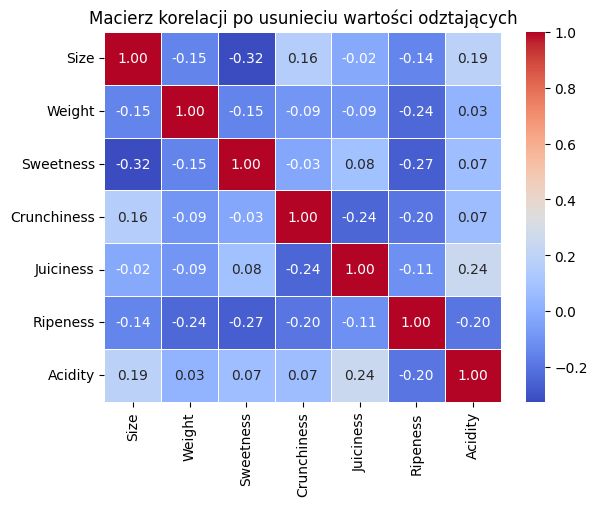

In [ ]:
# Wizualizacji macierzy po usunieciu wartości odstających
sns.heatmap(matrix_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Macierz korelacji po usunieciu wartości odztających');

In [ ]:
# Usuwam cechy z dyspersią < 0.1
selector = VarianceThreshold(threshold=0.01)
X_high_variance = selector.fit_transform(indep_var_no_outliers)

# Otrzymujemy nazwy pozostałych cech
selected_features = indep_var_no_outliers.columns[selector.get_support()]
X_selected = pd.DataFrame(X_high_variance, columns=selected_features)
X_selected

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984
...,...,...,...,...,...,...,...
3898,0.059386,-1.067408,-3.714549,0.473052,1.697986,2.244055,0.137784
3899,-0.293118,1.949253,-0.204020,-0.640196,0.024523,-1.087900,1.854235
3900,-2.634515,-2.138247,-2.440461,0.657223,2.199709,4.763859,-1.334611
3901,-4.008004,-1.779337,2.366397,-0.200329,2.161435,0.214488,-2.229720


In [ ]:
#Zmieniam dane porządkowe na numeryczne
le = LabelEncoder()
dep_var_encoded = le.fit_transform(dep_var_no_outliers) #Label encoding

#Obliczam wzajemną informację (mutual information) między cechami a zmienną zależną
#Funkcja mutual_info_classif mierzy, jak bardzo każda cecha jest powiązana z celem (dep_var_encoded)
mi = mutual_info_classif(X_selected, dep_var_encoded)

# Tworzę serię pandas z nazwami cech i wartościami mutual information, sortuję malejąco
mi_series = pd.Series(mi, index=X_selected.columns).sort_values(ascending=False)

print(f"Wartości mutual_info: \n{mi_series}")

Wartości mutual_info: 
Juiciness      0.040286
Sweetness      0.040207
Ripeness       0.030347
Weight         0.027493
Size           0.024215
Crunchiness    0.022558
Acidity        0.000000
dtype: float64


In [ ]:
#Wybieram tylko cechy, których wartość MI jest większa niż 0.02
important_features = mi_series[mi_series > 0.02].index
X_selected_filtered = X_selected[important_features]
important_features.tolist()

# - Acidity

['Juiciness', 'Sweetness', 'Ripeness', 'Weight', 'Size', 'Crunchiness']

In [ ]:
# Sprawdzam, czy potrzebuję transformację danych
skewness = X_selected_filtered.skew() #Skośność kolumn
skewness

# -> Nie ma dużej skosności, dlatego nie potrzebuję transformacji

,0
Juiciness,-0.071841
Sweetness,0.058080
Ripeness,-0.006179
Weight,-0.032626
Size,0.024626
Crunchiness,-0.042739


In [ ]:
#Skalowanie danych. StandardScaler() bo nie mam dużej skośności
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected_filtered)
X_scaled

array([[ 0.70446265,  3.04578598, -0.10099744, -0.98161862, -1.83390502,
        -1.4928514 ],
       [ 0.17727573,  2.16501638,  0.19135468, -1.19255806, -0.36235703,
         0.45521767],
       [ 1.23277698, -0.66350977, -0.30101684, -0.2324688 ,  0.11662428,
        -0.99135044],
       ...,
       [ 0.89309467, -1.03106565,  2.30986063, -0.74024388, -1.12564531,
        -0.24228331],
       [ 0.87274678,  1.48561268, -0.16371613, -0.5086638 , -1.85403343,
        -0.88475107],
       [ 0.39705331,  0.31012656, -0.70257364, -0.46747728,  0.4192054 ,
        -1.59928556]])

In [ ]:
# Nie mam PCA(), bo mam tylko 6 cech, to nie jest dużo

In [ ]:
# Budowa modelu liniowego (OLS)-standardowa metoda estymacji współczynników regresji liniowej.
#Celem jest znalezienie takich współczynników, które minimalizują sumę
#kwadratów błędów (różnic między wartościami przewidywanymi a obserwowanymi).
X_сonst = sm.add_constant(X_selected_filtered) # + wyraz wolny
y_ols = dep_var_encoded

model = sm.OLS(y_ols, X_сonst).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     228.3
Date:                Wed, 07 May 2025   Prob (F-statistic):          1.64e-250
Time:                        08:56:30   Log-Likelihood:                -2244.7
No. Observations:                3903   AIC:                             4503.
Df Residuals:                    3896   BIC:                             4547.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.6070      0.011     54.789      

In [ ]:

# Dep. Variable: y — zmienna zależna (to, co próbujemy przewidzieć).
# R-squared: 0.260 — współczynnik determinacji, czyli jak dużo wariancji zmiennej zależnej wyjaśnia model (26%).
# Adj. R-squared: 0.259 — skorygowany współczynnik determinacji, uwzględniający liczbę cech w modelu.
# F-statistic: 228.3, Prob (F-statistic): 1.64e-250 — test istotności całego modelu; bardzo niskie p oznacza, że model jest statystycznie istotny.
# No. Observations: 3903 — liczba obserwacji (próbek).
# Df Model: 6 — liczba współczynników (bez stałej).
# Df Residuals: 3896 — liczba stopni swobody dla reszt.
# Log-Likelihood, AIC, BIC — miary jakości modelu przydatne do porównywania modeli.

# coef — wartość współczynnika regresji, czyli o ile zmienia się zmienna zależna,
# gdy zmienna niezależna rośnie o 1 jednostkę, przy stałych pozostałych zmiennych.
# std err — błąd standardowy, miara precyzji estymacji współczynnika.
# t — statystyka t-testu sprawdzającego, czy współczynnik jest różny od zera.
# P>|t| — wartość p testu t; jeśli < 0.05, współczynnik jest statystycznie istotny.
# [0.025, 0.975] — 95% przedział ufności dla współczynnika.

# Wszystkie współczynniki poza Crunchiness są statystycznie istotne (p < 0.05).
# Crunchiness ma p=0.819, więc nie ma istotnego wpływu na zmienną zależną w tym modelu.

# Omnibus i Jarque-Bera — testy normalności rozkładu reszt. Niskie wartości p oznaczają
# odchylenia od normalności (w tym przypadku reszty nie są idealnie normalne).
# Durbin-Watson ~ 2 — test autokorelacji reszt (wartość bliska 2 oznacza brak autokorelacji).
# Skew — miara skośności rozkładu reszt (blisko 0 to rozkład symetryczny).
# Kurtosis — miara „spiczastości” rozkładu; wartość bliska 3 jest typowa dla rozkładu normalnego.
# Cond. No. — liczba kondycji, wskazuje na problem wielokolinarności. Wartość ~4.28 jest niska, więc problemu nie ma.

# Podsumowanie
# Model wyjaśnia około 26% wariancji zmiennej zależnej — umiarkowana siła predykcji.
# Większość cech jest statystycznie istotna.
# Warto rozważyć usunięcie zmiennej Crunchiness, bo nie wnosi istotnej informacji.
# Reszty nie są idealnie normalne, ale brak autokorelacji jest dobry.
# Model spełnia podstawowe założenia liniowej regresji.

In [ ]:
"""
Weryfikacja założeń regresji liniowej (sprawdzenie założeń modelu)

-Liniowość: Zrób wykres rozrzutu (scatter plot) między każdą cechą a zmienną zależną.
-Homoscedastyczność: Stwórz wykres reszt (residuals) względem przewidywanych wartości, sprawdź jednorodność wariancji.
-Normalność reszt: Zrób wykres Q-Q (quantile-quantile plot), aby sprawdzić normalność reszt.
-Brak wielokolinearności: Oblicz VIF (współczynnik inflacji wariancji) dla cech, aby wykluczyć wielokolinearność.
-Optymalizacja i wnioski

-Jeśli coś jest nie tak, spróbuj usunąć cechy o wysokiej wielokolinearności.
-Przeanalizuj ponownie transformacje i skalowanie.
-Opcjonalnie: Spróbuj innych modeli, jeśli regresja liniowa nie pasuje.
"""

'\nWeryfikacja założeń regresji liniowej (sprawdzenie założeń modelu)\n\n-Liniowość: Zrób wykres rozrzutu (scatter plot) między każdą cechą a zmienną zależną.\n-Homoscedastyczność: Stwórz wykres reszt (residuals) względem przewidywanych wartości, sprawdź jednorodność wariancji.\n-Normalność reszt: Zrób wykres Q-Q (quantile-quantile plot), aby sprawdzić normalność reszt.\n-Brak wielokolinearności: Oblicz VIF (współczynnik inflacji wariancji) dla cech, aby wykluczyć wielokolinearność.\n-Optymalizacja i wnioski\n\n-Jeśli coś jest nie tak, spróbuj usunąć cechy o wysokiej wielokolinearności.\n-Przeanalizuj ponownie transformacje i skalowanie.\n-Opcjonalnie: Spróbuj innych modeli, jeśli regresja liniowa nie pasuje.\n'

# ПЕРЕПРОВЕРКА ЛИНЕЙНОСТИ

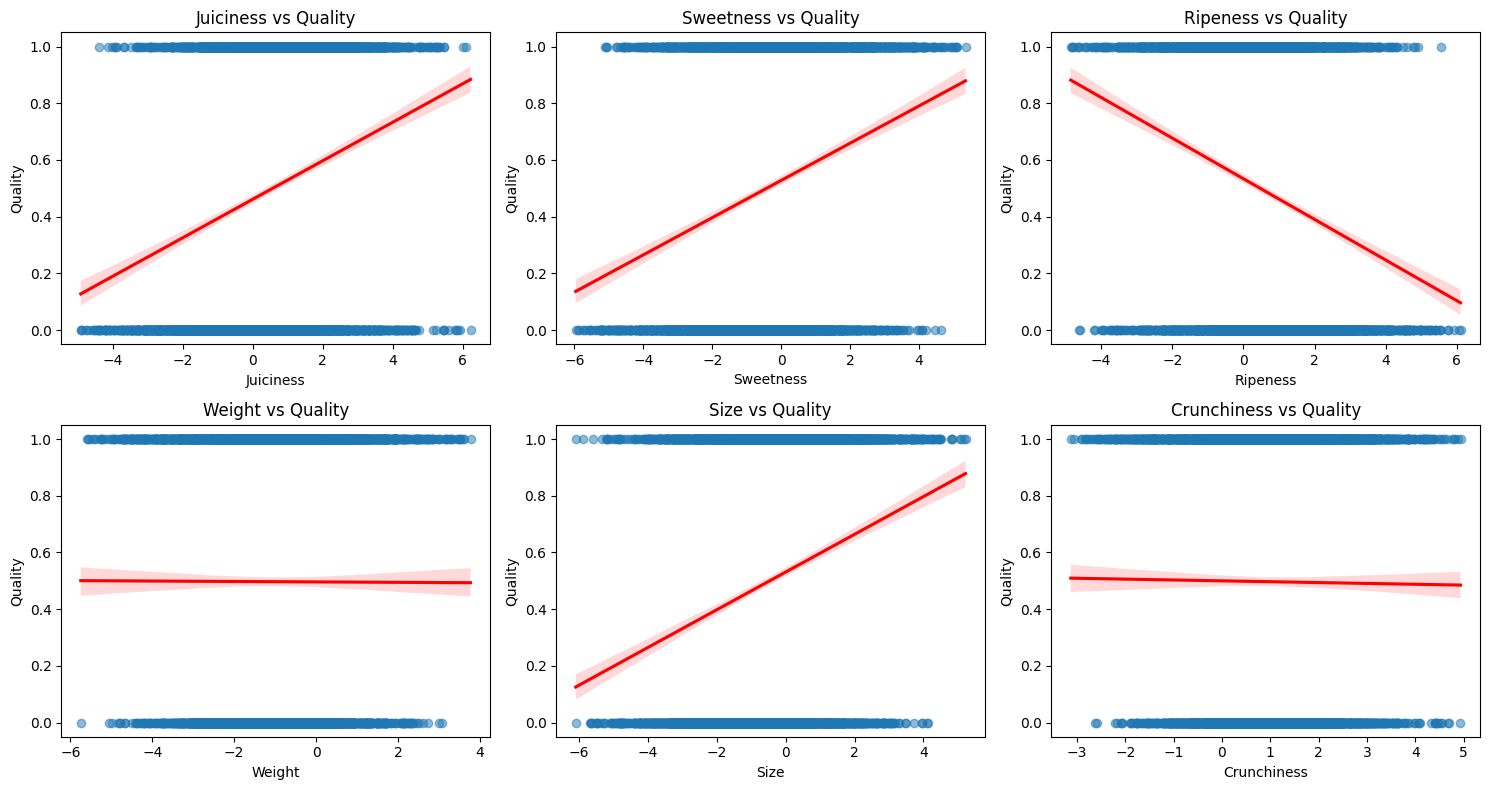

In [ ]:
# Liniowość(wykresy rozrzutu)
df = X_selected_filtered.copy() #kopia danych z dodawaniem kolumny Quality
df['Quality'] = dep_var_encoded  # zakodowana jako 0 i 1

# Lista zmiennych niezależnych
features = df.columns[:-1]

# Siatka wykresów
n_features = len(features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 5, n_rows * 4))
for idx, feature in enumerate(features):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.regplot(x=feature, y='Quality', data=df, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'}) # czerwona linia - regresji
    plt.title(f'{feature} vs Quality')
plt.tight_layout();

In [ ]:
#Im bardziej soczysty owoc, tym WIĘKSZE prawdopodobieństwo, że zostanie oceniony jako „good”
#Im słodszy owoc, tym WIĘKSZE prawdopodobieństwo, że zostanie oceniony jako „good”
#Im bardziej dojrzały owoc, tym MNIEJSZE prawdopodobieństwo, że będzie oceniony jako „good”
#Waga owocu NIE WPŁYWA na ocenę jakości. Zależnośc nie jest liniowa
#Im większy owoc, tym WIĘKSZE prawdopodobieństwo, że będzie oceniony jako „good”
#Chrupkość NIE WPŁYWA na ocenę jakości. Zależnośc nie jest liniowa

# Непонятно, что с гомоскедантичностью


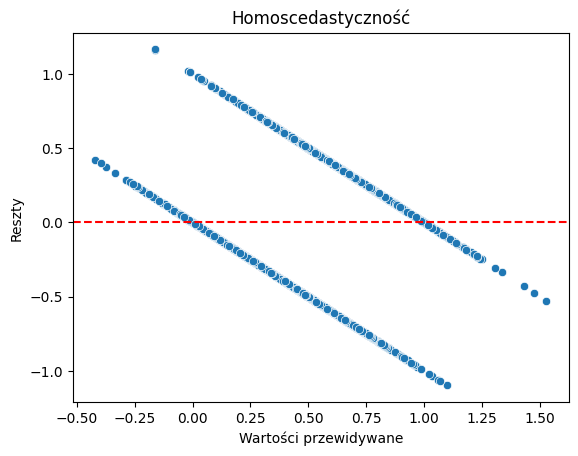

In [ ]:
#Homoscedastyczność (czy rozrzut reszt (błędów) jest taki sam dla wszystkich wartości zmiennych niezależnych)

#w-ści przewidywane
y_pred = model.predict(X_сonst)
#reszty(błąd: rzeczywista wartość - przewidywana)
residuals = y_ols - y_pred

sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Wartości przewidywane")
plt.ylabel("Reszty")
plt.title("Homoscedastyczność");

In [ ]:
import statsmodels.stats.api as sms
test = sms.het_breuschpagan(residuals, X_сonst)
print(f"Statystyka LM: {test[0]}, p-value: {test[1]}")

Statystyka LM: 448.1649816243461, p-value: 1.2186324846379516e-93


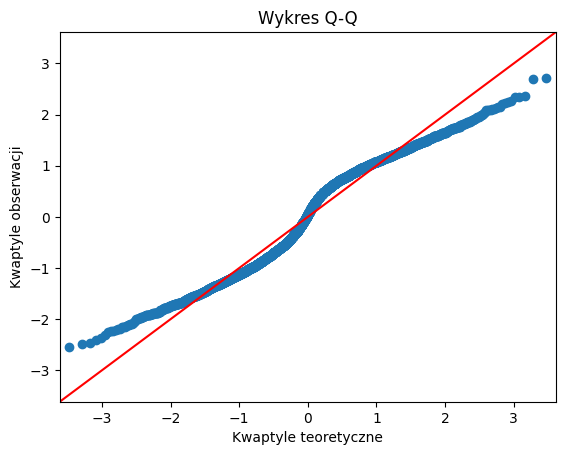

In [ ]:
#Normalność reszt -> mam odchylenia w dolnej i górnej częśći wykresu, co może wskazywać na nienormalność
sm.qqplot(residuals, line='45', fit=True)
plt.title('Wykres Q-Q')
plt.xlabel('Kwарtyle teoretyczne')
plt.ylabel('Kwарtyle obserwacji');

In [ ]:
#Sprawdzenie współliniowości (multikolinearności) przy użyciu wskaźnika VIF (Variance Inflation Factor)
vif_data = pd.DataFrame()
vif_data["Variable"] = X_сonst.columns
vif_data["VIF"] = [variance_inflation_factor(X_сonst.values, i) for i in range(X_сonst.shape[1])]
print(vif_data)
# -> Brak silnych korelacji między zmiennymi niezależnymi. Nie ma problemu z multikolinearnością

      Variable       VIF
0        const  2.585209
1    Juiciness  1.122982
2    Sweetness  1.441209
3     Ripeness  1.461129
4       Weight  1.304886
5         Size  1.335983
6  Crunchiness  1.181534


In [ ]:
# Podział danych na zbiór treningowy (80%) i testowy (20%)
# X_selected_filtered - Zmienne niezależne
# dep_var_encoded - Zmienna zależna

X_train, X_test, y_train, y_test = train_test_split(X_selected_filtered, dep_var_encoded, test_size=0.2, random_state=42)

# Sprawdzenie kształtu danych
print(f'Zbiór treningowy X: {X_train.shape}')
print(f'Zbiór testowy X: {X_test.shape}')
# 6 - liczba cech

Zbiór treningowy X: (3122, 6)
Zbiór testowy X: (781, 6)


In [ ]:
#Trenowanie modelu (regresja logistyczna)
model = LogisticRegression() #dlatego że mam Quality(0/1)
model.fit(X_train, y_train)

# fit - dopasowuje model do danych treningowych / optymalizuje parametry modelu w celu minimalizacji błędu

LogisticRegression()

In [ ]:
# Ocenianie dokładności modelu na zbiorze testowym

# Predykcja na zbiorze testowym
y_pred = model.predict(X_test)

# Ocena dokładności modelu
accuracy = accuracy_score(y_test, y_pred)
print(f'Dokładność modelu na zbiorze testowym: {accuracy:.4f}')

# -> model poprawnie przewidział 73.5% przypadków w zbiorze testowym.

Dokładność modelu na zbiorze testowym: 0.7350


In [ ]:
#???????

# Obliczenie precyzji, czułości i F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precyzja: {precision:.4f}')
print(f'Czułość: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

#Precyzja wynosi 0.7315. Oznacza to, że spośród wszystkich przypadków, które model przewidział jako pozytywne
#(np. 1), 73.15% były rzeczywiście pozytywne.
#Precyzja mówi, jak bardzo jesteśmy pewni, że model nie popełnia błędu przy przewidywaniu klasy pozytywnej

#Czułość wynosi 0.7371. Oznacza to, że model wykrył 73.71% wszystkich rzeczywistych przypadków pozytywnych (np. przypadków 1).
#Czułość mówi, jak dobrze model potrafi wykryć wszystkie przypadki pozytywne w zbiorze danych.
#Im wyższa czułość, tym lepiej model radzi sobie z wykrywaniem przypadków pozytywnych, ale przy
#tym ryzykuje większą liczbą fałszywych pozytywów.

#F1-score wynosi 0.7343. Jest to średnia harmonijna precyzji i czułości, która stanowi balans między tymi dwoma metrykami.
#Jest szczególnie przydatna, gdy zależy Ci na dobrym kompromisie pomiędzy precyzją a czułością.
#F1-score jest idealną miarą, gdy masz nierównomierne klasy (np. jedna klasa jest znacznie mniejsza niż druga)
#i zależy Ci na uzyskaniu zarówno wysokiej precyzji, jak i wysokiej czułości.
#Jeśli F1-score jest wysoki, oznacza to, że model dobrze radzi sobie zarówno z unikaniem fałszywych pozytywów,
#jak i z wykrywaniem pozytywnych przypadków.


Precyzja: 0.7315
Czułość: 0.7371
F1-score: 0.7343


# Модель можно улучшить, чтобы точность была выше

In [ ]:
# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
print('Macierz pomyłek:')
print(cm)

#Macierz pomyłek pokazuje, jak model klasyfikuje przypadki w czterech kategoriach: [[(R0, P0), (R0, P1)
#                                                                                   (R1, P0), (R1, P1)]]

Macierz pomyłek:
[[288 105]
 [102 286]]


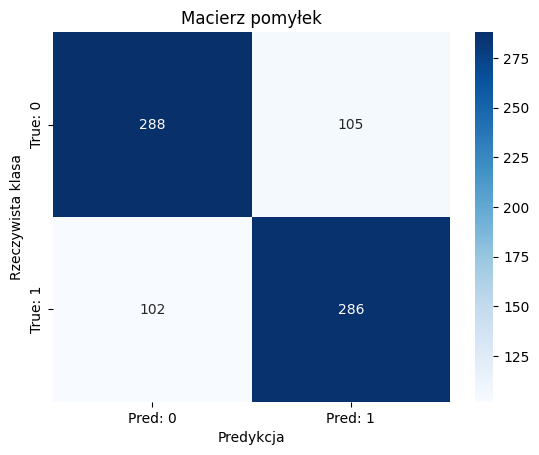

In [ ]:
# Wizualizacja
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: 0', 'Pred: 1'], yticklabels=['True: 0', 'True: 1'])
plt.title('Macierz pomyłek')
plt.xlabel('Predykcja')
plt.ylabel('Rzeczywista klasa');

# ОТСЮДА НАДО ПЕРЕПРОВЕРЯТЬ

MSE: 0.1027
RMSE: 0.3204
R²: 0.5894


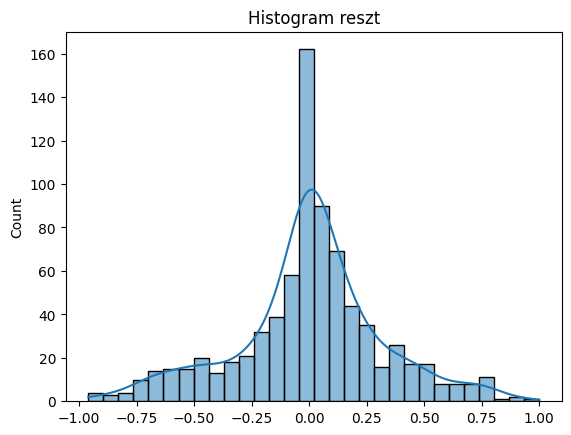

In [ ]:
# Wybrana zmienna docelowa i cechy
X = df.drop(columns=['Juiciness', 'Quality'])  # usuwam Quality (jest binarna)
y = df['Juiciness']

X_train, X_test, y_train, y_test = train_test_split(X_selected_filtered, dep_var_encoded, test_size=0.2, random_state=42)
model = RandomForestRegressor() # or LinearRegression(), ale r^2 jest mniejszy i histogram nie wygłąda jako rozkład normalny
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Analiza reszt
residuals = y_test - y_pred
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram reszt');


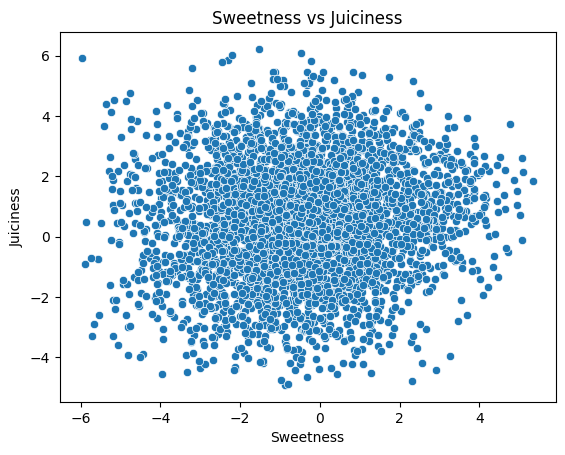

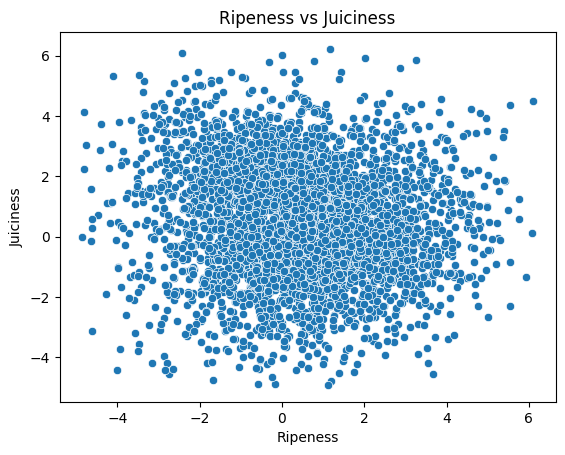

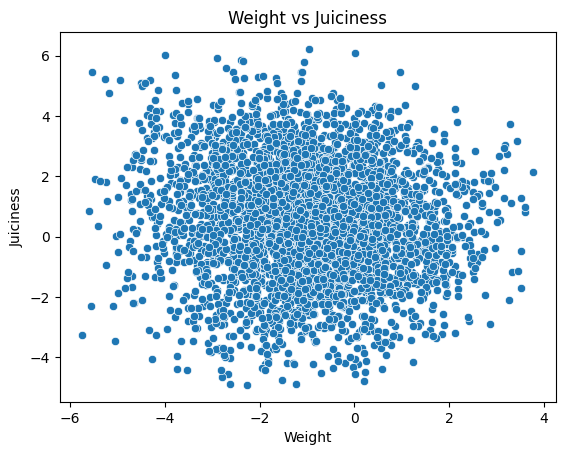

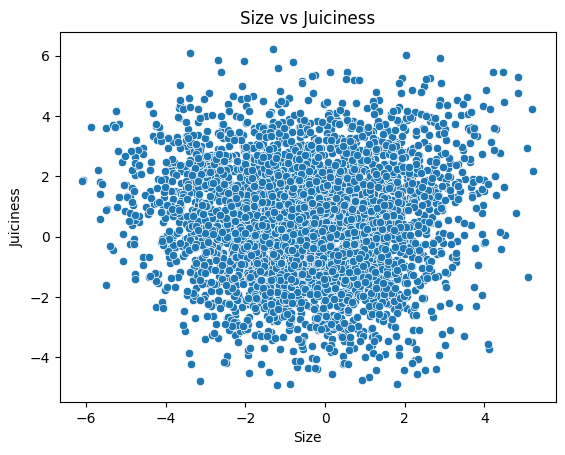

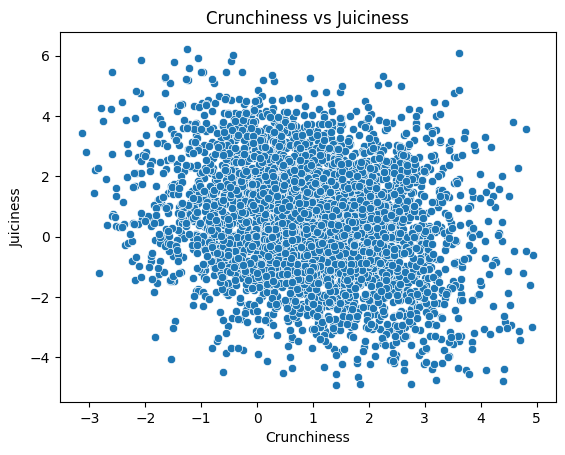

In [ ]:
# Wizualizacja zależności
#wykresy rozrzutu dla pary cecha docelowa ↔ zmienna objaśniająca:
for col in X.columns:
  sns.scatterplot(data=df, x=col, y=y)
  plt.title(f'{col} vs {y.name}')
  plt.show()

In [ ]:
correlation = df.corr(method='pearson')
print(correlation)

             Juiciness  Sweetness  Ripeness    Weight      Size  Crunchiness  \
Juiciness     1.000000   0.084672 -0.107505 -0.088784 -0.018156    -0.242160   
Sweetness     0.084672   1.000000 -0.272663 -0.153337 -0.324508    -0.029287   
Ripeness     -0.107505  -0.272663  1.000000 -0.237118 -0.144195    -0.198083   
Weight       -0.088784  -0.153337 -0.237118  1.000000 -0.153762    -0.087360   
Size         -0.018156  -0.324508 -0.144195 -0.153762  1.000000     0.160858   
Crunchiness  -0.242160  -0.029287 -0.198083 -0.087360  0.160858     1.000000   
Quality       0.255120   0.250919 -0.263725 -0.002363  0.250662    -0.008072   

              Quality  
Juiciness    0.255120  
Sweetness    0.250919  
Ripeness    -0.263725  
Weight      -0.002363  
Size         0.250662  
Crunchiness -0.008072  
Quality      1.000000  


#Не понимаю, линейная ли зависимость


In [ ]:
#model nie jest liniowa, dlatego szukam nieliniowy zależności za pomocą RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("R²:", r2_score(y_test, y_pred))

R²: 0.5979154022717138


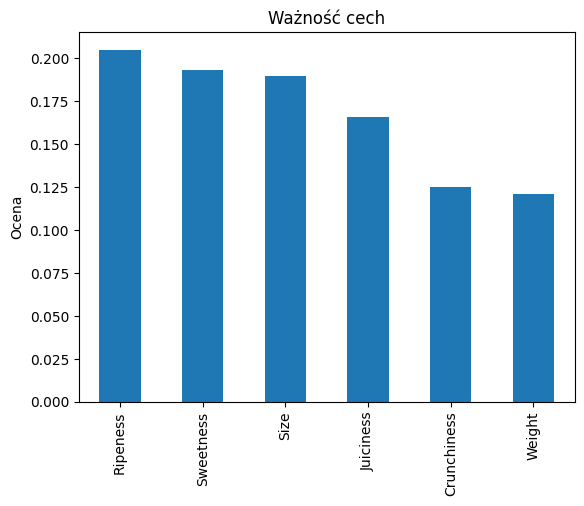

In [ ]:
#Iteracyjne modyfikacje cech

# które zmienne mają największy wpływ na przewidywania modelu.
importances = model.feature_importances_
feature_names = X_train.columns

# Tabela ważności
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Wizualizacja
feat_imp.plot(kind='bar', title='Ważność cech')
plt.ylabel('Ocena');

# Перепроверить

R² (współczynnik determinacji) wskazuje, jaką część zmienności zmiennej zależnej wyjaśnia model. Im wyższe R², tym lepsza zdolność modelu do wyjaśnienia tej zmienności.

R² = 1 — idealny model, który wyjaśnia 100% zmienności zmiennej zależnej.

R² = 0 — model nie wyjaśnia wcale zmienności, jest to porównywalne z losowymi przewidywaniami.

R² < 0 — model jest gorszy od losowych przewidywań. Może to sugerować, że model jest źle dopasowany lub zbytnio dopasowany do danych treningowych (przeuczenie).

---

MSE mierzy średnią z kwadratów różnic między przewidywaniami modelu a rzeczywistymi wartościami. Im niższa wartość MSE, tym dokładniejszy model.

MSE = 0 — idealne przewidywanie.

MSE > 0 — im wyższe MSE, tym model jest mniej dokładny.

---

RMSE to pierwiastek kwadratowy z MSE, co pozwala uzyskać miarę błędu w tych samych jednostkach, co zmienna zależna. To ułatwia interpretację.

Im niższe RMSE, tym lepsze dopasowanie modelu.

---

Ridge (regularizacja L2): Ta metoda zmniejsza wpływ silnie skorelowanych cech, ale nie usuwa ich z modelu. Jeśli R² wzrosło, oznacza to, że regularizacja pomogła uniknąć przeuczenia i poprawiła stabilność modelu.

Lasso (regularizacja L1): Lasso może usunąć (zerować) niektóre cechy, co jest korzystne w przypadku dużej liczby cech, które mają mały wpływ na zmienną zależną. Jeśli niektóre współczynniki stały się zerowe, może to oznaczać, że model był zbyt skomplikowany i Lasso go uprościło.

---

Optymalna wartość parametru regularizacji (alpha):

W Ridge i Lasso parametr alpha kontroluje siłę regularizacji.
Im większa wartość alpha, tym silniejsza jest regularizacja, a wpływ cech jest mniejszy.

W Ridge oznacza to, że model generuje bardziej „gładkie” prognozy, zmniejszając wpływ silnych korelacji między cechami.
W Lasso może to oznaczać usunięcie (zerowanie) cech, co prowadzi do prostszej wersji modelu.

---

Porównując wyniki modeli z i bez regularizacji, możemy sprawdzić, czy regularizacja poprawiła dokładność modelu. Jeśli R² lub MSE dla modelu z regularizacją są lepsze, oznacza to, że regularizacja poprawiła stabilność modelu i zmniejszyła przeuczenie.

---

GridSearchCV pomaga znaleźć najlepsze hiperparametry dla modelu. Na przykład, jeśli dostosowujesz parametr alpha w Ridge lub Lasso, GridSearchCV sprawdza różne wartości i wybiera tę, która daje najlepsze wyniki.

Interpretacja wyników GridSearchCV:

Najlepsze parametry: GridSearchCV zwraca optymalne wartości hiperparametrów, na przykład, najlepsza wartość alpha w przypadku Ridge. Jeśli najlepszy wynik to alpha = 1.0, oznacza to, że model działa najlepiej przy tej wartości.
Najlepszy wynik kroswalidacji: GridSearchCV pokazuje, jak model radzi sobie z nieznanymi danymi. Im wyższy wynik, tym lepsza zdolność modelu do generalizacji.

---

W przypadku używania Lasso regularizacja może prowadzić do zerowania niektórych współczynników, co oznacza, że te cechy zostały usunięte z modelu. Możesz sprawdzić, które cechy zostały wykluczone i które mają największy wpływ na wynik.

---

Załóżmy, że zastosowałeś Ridge i Lasso, a wyniki wyglądają następująco:

R² dla Ridge: 0.75

R² dla Lasso: 0.73

MSE dla Ridge: 0.30

MSE dla Lasso: 0.35

Interpretacja:
R²: Model z Ridge wyjaśnia 75% zmienności zmiennej zależnej, co jest dobrym wynikiem. Lasso wyjaśnia 73%, co jest nieco mniejsze, ale nadal dobry wynik.

MSE: Model z Ridge ma mniejsze MSE, co oznacza, że jego przewidywania są bardziej dokładne niż te z Lasso.

Lasso może usunąć niektóre cechy, co prowadzi do uproszczenia modelu. To może być korzystne, jeśli dane zawierają cechy, które nie mają istotnego wpływu na wynik.

Jeśli R² i MSE dla modeli z regularizacją (Ridge, Lasso) są lepsze niż dla zwykłej regresji liniowej, oznacza to, że regularizacja poprawiła model i zmniejszyła ryzyko przeuczenia.


In [ ]:
ridge = Ridge(alpha=1.0)  # alpha — hiperparametr regularyzacji
ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)

# Ocena modelu
from sklearn.metrics import mean_squared_error, r2_score
print("MSE dla Ridge:", mean_squared_error(y_test, y_pred_ridge))
print("R² dla Ridge:", r2_score(y_test, y_pred_ridge))

#Ridge działa najlepiej niż Lasso, ale model wyjaśnia tylko 24% zmienności

MSE for Ridge: 0.1893995808119146
R² for Ridge: 0.24237062438277968


In [ ]:
lasso = Lasso(alpha=0.1)  # alpha — hiperparametr regularyzacji
lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)

# Ocena modelu
print("MSE dla Lasso:", mean_squared_error(y_test, y_pred_lasso))
print("R² dla Lasso:", r2_score(y_test, y_pred_lasso))

MSE for Lasso: 0.19947032595608027
R² for Lasso: 0.2020859926910583


In [ ]:
#Dostrajanie parametrów GridSearchCV
param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}

# model dla Ridge()
ridge = Ridge()

grid_search = GridSearchCV(ridge, param_grid, cv=5)  # cv=5 — walidacja krzyżowa
grid_search.fit(X_train, y_train)

print("Najlepszy hiperparametr dla Ridge:", grid_search.best_params_)
print("Najlepszy wynik R² dla Ridge:", grid_search.best_score_)

y_pred_best_ridge = grid_search.predict(X_test)
print("R² na danych testowych:", r2_score(y_test, y_pred_best_ridge))

Najlepszy hiperparametr dla Ridge: {'alpha': 10.0}
Najlepszy wynik R² dla Ridge: 0.25638626526320357
R² na danych testowych: 0.2424469694554221


In [ ]:
param_grid_lasso = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}

lasso = Lasso()

grid_search_lasso = GridSearchCV(lasso, param_grid_lasso, cv=5)
grid_search_lasso.fit(X_train, y_train)

print("Najlepszy hiperparametr dla Lasso:", grid_search_lasso.best_params_)
print("Najlepszy wynik R² dla Lasso:", grid_search_lasso.best_score_)

y_pred_best_lasso = grid_search_lasso.predict(X_test)
print("R² na danych testowych:", r2_score(y_test, y_pred_best_lasso))

Najlepszy hiperparametr dla Lasso: {'alpha': 0.1}
Najlepszy wynik R² dla Lasso: 0.19999553748005686
R² na danych testowych: 0.2020859926910583


In [ ]:
#łączenie etapów przetwarzania
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standaryzacja danych
    ('ridge', Ridge(alpha=1.0))  # Model z regularizacją
])

pipeline.fit(X_train, y_train)
y_pred_pipeline = pipeline.predict(X_test)

print("R² na danych testowych: (Pipeline):", r2_score(y_test, y_pred_pipeline))

R² na danych testowych: (Pipeline): 0.2423904131200596


In [ ]:
# # Parametry siatki
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5],
# }

# # Model
# rf = RandomForestRegressor(random_state=42)

# # GridSearch z walidacją krzyżową i przyspieszeniem (n_jobs=-1)
# grid_search = GridSearchCV(
#     estimator=rf,
#     param_grid=param_grid,
#     cv=5,
#     n_jobs=-1,  # Wszystkie rdzeni procesora
#     verbose=2   # Postęp
# )

# start = time.time()
# grid_search.fit(X_train, y_train)
# end = time.time()

# print(f"Czas obliczeń: {end - start:.2f} sekund")
# print("Najlepsze parametry:", grid_search.best_params_)
# print("Najlepszy wynik R² na treningu (CV):", grid_search.best_score_)

# y_pred_rf = grid_search.predict(X_test)
# print("R² na danych testowych:", r2_score(y_test, y_pred_rf))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Czas obliczeń: 110.53 sekund
Najlepsze parametry: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Najlepszy wynik R² na treningu (CV): 0.579372923239611
R² na danych testowych: 0.5977257848672746
